## A Numeric Study for Univariate Uncertainty Propagation

Multi-fidelity uncertainty propagation using polynomial chaos and Gaussian process modeling

[https://doi.org/10.1007/s00158-019-02287-7](https://doi.org/10.1007/s00158-019-02287-7)


### Study 1:

$$ y_a = (6x-2)^2 sin(12x-4) $$

$$ y_b = 0.5(6x-2)^2 sin(12x-4) + 8(x-0.5) + 5  $$

Case 1: $$ x \sim \mathcal{N}(0.5, 0.5)  $$

Case 2: $$ x \sim \mathcal{B}(5, 0.75) $$

In [5]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

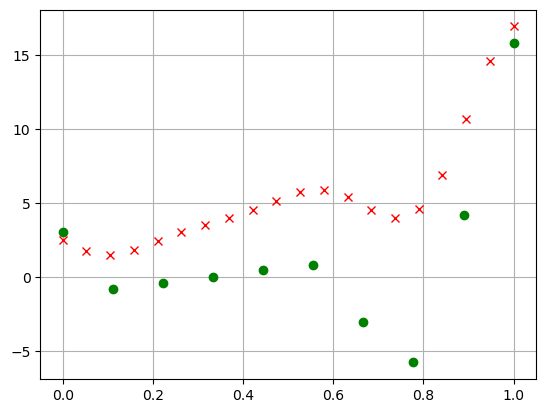

In [6]:
# define the simulator

def sim1a(x):
    return (6*x-2)**2 * np.sin(12*x-4)

def sim1b(x):
    return 0.5*(6*x-2)**2 * np.sin(12*x-4) + 8*(x-0.5) + 5

X1as = np.linspace(0, 1, 10)
X1bs = np.linspace(0, 1, 20)
plt.plot(X1as, [sim1a(xs) for xs in X1as], 'o', color='green', label="data,A")
plt.plot(X1bs, [sim1b(xs) for xs in X1bs], 'x', color='red', label="data,B")
plt.grid()

#### Monte Carlo

In [7]:
import time

start_time = time.time()

num_samples = int(5e7)  # number of Monte Carlo samples

random_seed = np.random.randint(0, 100000)
np.random.seed(random_seed)

# Sample from normal distributions based on credible intervals
x1_samples = np.random.normal(0.5, 0.5, num_samples)
#x1_samples = np.random.beta(5, 0.75, num_samples)

# Collect outputs
y1s = []

for i in range(num_samples):
    y1s.append(sim1a(x1_samples[i]))

y1s = np.array(y1s)

end_time = time.time()
print(f"The Monte Carlo simulation had {num_samples} trials and took {(end_time-start_time)/60:.2f} minutes.")
print(f"The random seed used was: {random_seed}")

# Example output: the final concentrations of each species for each Monte Carlo sample
y1s

The Monte Carlo simulation had 50000000 trials and took 0.61 minutes.
The random seed used was: 2652


array([ -0.07977635, -14.02269966,  15.66427611, ...,   2.3897939 ,
       -13.51402401,  -0.44933019])

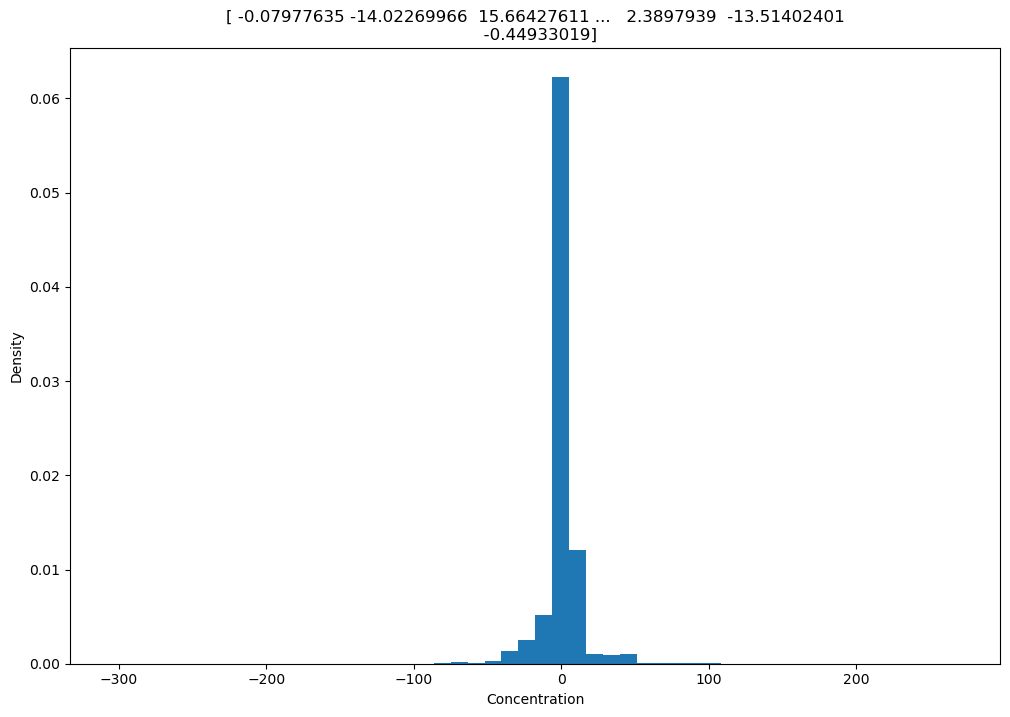

{'mean': -0.0015923239957873416,
 'median': -3.6766482953932314e-09,
 'std_dev': 12.208170511820127}

In [8]:
plt.figure(figsize=(12, 8))
plt.hist(y1s, bins=50, density=True)
plt.title(y1s)
plt.xlabel('Concentration')
plt.ylabel('Density')
plt.show()

# Calculate and print statistical properties
stat_properties = {}

stat_properties["mean"] = np.mean(y1s)
stat_properties["median"] = np.median(y1s)
stat_properties["std_dev"] = np.std(y1s)
stat_properties